In [1]:
import sys
import pickle
import numpy as np
import pandas as pd

sys.path.append('../')

In [2]:
from src.GraphWisconsin.model_GNN import GCNReg
from src.GraphWisconsin.generate_graph_dataset import graph_dataset, collate

# initialize the model

In [3]:
model = GCNReg(in_dim=74, hidden_dim=256, n_classes=1)
model

GCNReg(
  (conv1): GraphConv(in=74, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify1): Linear(in_features=256, out_features=256, bias=True)
  (classify2): Linear(in_features=256, out_features=256, bias=True)
  (classify3): Linear(in_features=256, out_features=1, bias=True)
)

# load data

In [4]:
path = '../models/GCN_early_stop' # or '../models/GCN'

smlstr_train = pickle.load(open(f"{path}/smlstr_train.p","rb"))
smlstr_test = pickle.load(open(f"{path}/smlstr_test.p","rb"))

logCMC_train = pickle.load(open(f"{path}/logCMC_train.p","rb"))
logCMC_test = pickle.load(open(f"{path}/logCMC_test.p","rb"))

In [6]:
train_full_dataset = graph_dataset(smlstr_train,logCMC_train)
test_dataset = graph_dataset(smlstr_test,logCMC_test)

# Load pretained model

In [7]:
import torch
import torch.nn as nn
import glob
import os

In [8]:
train_loader = torch.utils.data.DataLoader(train_full_dataset, batch_size=1,
                                                   collate_fn=collate,
                                                   shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                                  collate_fn=collate,
                                                  shuffle=False)

In [9]:
def get_predictions(data_loader):

    y_pred = []
    y_true = []

    for data in data_loader:
        graph = data[0] 
        label = data[1]
            
        label = label.view(-1,1)
        output = model(graph)
        y_true.append(label.float())
        y_pred.append(output)


    y_true = [[t.cpu().detach().numpy()[0] for t in sublist][0] for sublist in y_true]

    y_pred = [t.cpu().detach().numpy()[0][0] for t in y_pred if t.grad_fn is not None]
   

    return y_true, y_pred

In [13]:
model.eval()

for data in test_loader:
    graph = data[0] 
    label = data[1]
            
    label = label.view(-1,1)
    output = model(graph)

    print(output)
    # break


tensor([[-1.5946]], grad_fn=<AddmmBackward0>)
tensor([[-0.4758]], grad_fn=<AddmmBackward0>)
tensor([[-1.5353]], grad_fn=<AddmmBackward0>)
tensor([[1.2603]], grad_fn=<AddmmBackward0>)
tensor([[0.4584]], grad_fn=<AddmmBackward0>)
tensor([[-1.1638]], grad_fn=<AddmmBackward0>)
tensor([[-1.1679]], grad_fn=<AddmmBackward0>)
tensor([[-1.1838]], grad_fn=<AddmmBackward0>)
tensor([[-0.4424]], grad_fn=<AddmmBackward0>)
tensor([[-1.2271]], grad_fn=<AddmmBackward0>)
tensor([[-2.0726]], grad_fn=<AddmmBackward0>)
tensor([[-1.1264]], grad_fn=<AddmmBackward0>)
tensor([[-0.8647]], grad_fn=<AddmmBackward0>)
tensor([[-1.8442]], grad_fn=<AddmmBackward0>)
tensor([[-1.8200]], grad_fn=<AddmmBackward0>)
tensor([[-0.6114]], grad_fn=<AddmmBackward0>)
tensor([[-2.4119]], grad_fn=<AddmmBackward0>)
tensor([[-0.8487]], grad_fn=<AddmmBackward0>)
tensor([[-1.0892]], grad_fn=<AddmmBackward0>)
tensor([[-0.1530]], grad_fn=<AddmmBackward0>)
tensor([[1.0601]], grad_fn=<AddmmBackward0>)
tensor([[1.7759]], grad_fn=<AddmmBack

In [10]:
tar_files = glob.glob(path + '/*.tar')

checkpoints = {}
models = {}
train = {}
test = {}
     
for tar_file in tar_files:

    # load checkpoint
    checkpoint = torch.load(tar_file)
    checkpoint_name = os.path.basename(tar_file).replace('.tar', '')
    checkpoints[checkpoint_name] = checkpoint

    # load model with checkpoint
    try:
        model.load_state_dict(checkpoint['state_dict'])
    except:
        model.load_state_dict(checkpoint['model_state_dict'])
    models[checkpoint_name] = model

    model.eval()

    train[checkpoint_name] = get_predictions(train_loader)
    test[checkpoint_name] = get_predictions(test_loader)

In [10]:
train.keys()

dict_keys(['ep1000bs5lr0.005kf11hu256cvid5es.pth', 'ep1000bs5lr0.005kf11hu256cvid3.pth', 'ep1000bs5lr0.005kf11hu256cvid8es.pth', 'ep1000bs5lr0.005kf11hu256cvid2.pth', 'ep1000bs5lr0.005kf11hu256cvid3es.pth', 'ep1000bs5lr0.005kf11hu256cvid0.pth', 'ep1000bs5lr0.005kf11hu256cvid4es.pth', 'ep1000bs5lr0.005kf11hu256cvid9.pth', 'ep1000bs5lr0.005kf11hu256cvid10.pth', 'ep1000bs5lr0.005kf11hu256cvid9es.pth', 'ep1000bs5lr0.005kf11hu256cvid2es.pth', 'ep1000bs5lr0.005kf11hu256cvid8.pth', 'ep1000bs5lr0.005kf11hu256cvid1.pth', 'ep1000bs5lr0.005kf11hu256cvid7es.pth', 'ep1000bs5lr0.005kf11hu256cvid4.pth', 'ep1000bs5lr0.005kf11hu256cvid1es.pth', 'ep1000bs5lr0.005kf11hu256cvid5.pth', 'ep1000bs5lr0.005kf11hu256cvid6es.pth', 'ep1000bs5lr0.005kf11hu256cvid7.pth', 'ep1000bs5lr0.005kf11hu256cvid0es.pth', 'ep1000bs5lr0.005kf11hu256cvid6.pth', 'ep1000bs5lr0.005kf11hu256cvid10es.pth'])

# Plot Data

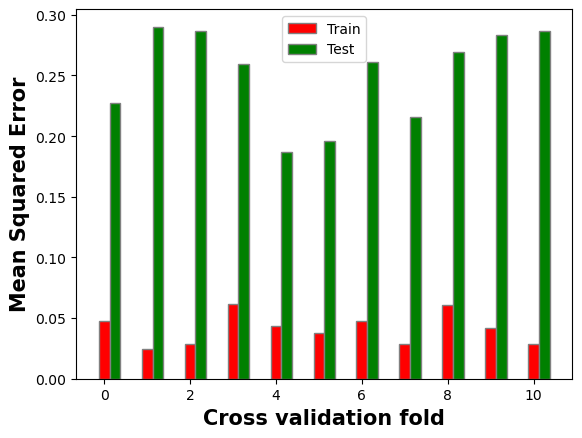

In [11]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Compute the MSE for each key
mse_values_train = {}
mse_values_test = {}

for key in range(11):  # Assuming keys are integers from 0 to 10
    
    exp_train = train[f'ep1000bs5lr0.005kf11hu256cvid{key}.pth'][0]
    pred_train = train[f'ep1000bs5lr0.005kf11hu256cvid{key}.pth'][1]
    exp_test = test[f'ep1000bs5lr0.005kf11hu256cvid{key}.pth'][0]
    pred_test = test[f'ep1000bs5lr0.005kf11hu256cvid{key}.pth'][1]

    mse_values_train[key] = mean_squared_error(exp_train, pred_train)
    mse_values_test[key] = mean_squared_error(exp_test, pred_test)


# Prepare the data for plotting
keys_train = list(mse_values_train.keys())
values_train = list(mse_values_train.values())

keys_test = list(mse_values_test.keys())
values_test = list(mse_values_test.values())

# Create the bar chart
# Set position of bar on X axis
barWidth = 0.25
br1 = np.arange(len(keys_train))
br2 = [x + barWidth for x in br1]
 
plt.bar(br1, values_train, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train')
plt.bar(br2, values_test, color ='g', width = barWidth,
        edgecolor ='grey', label ='Test')
 
plt.xlabel('Cross validation fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Mean Squared Error', fontweight ='bold', fontsize = 15)

plt.legend()
plt.show()


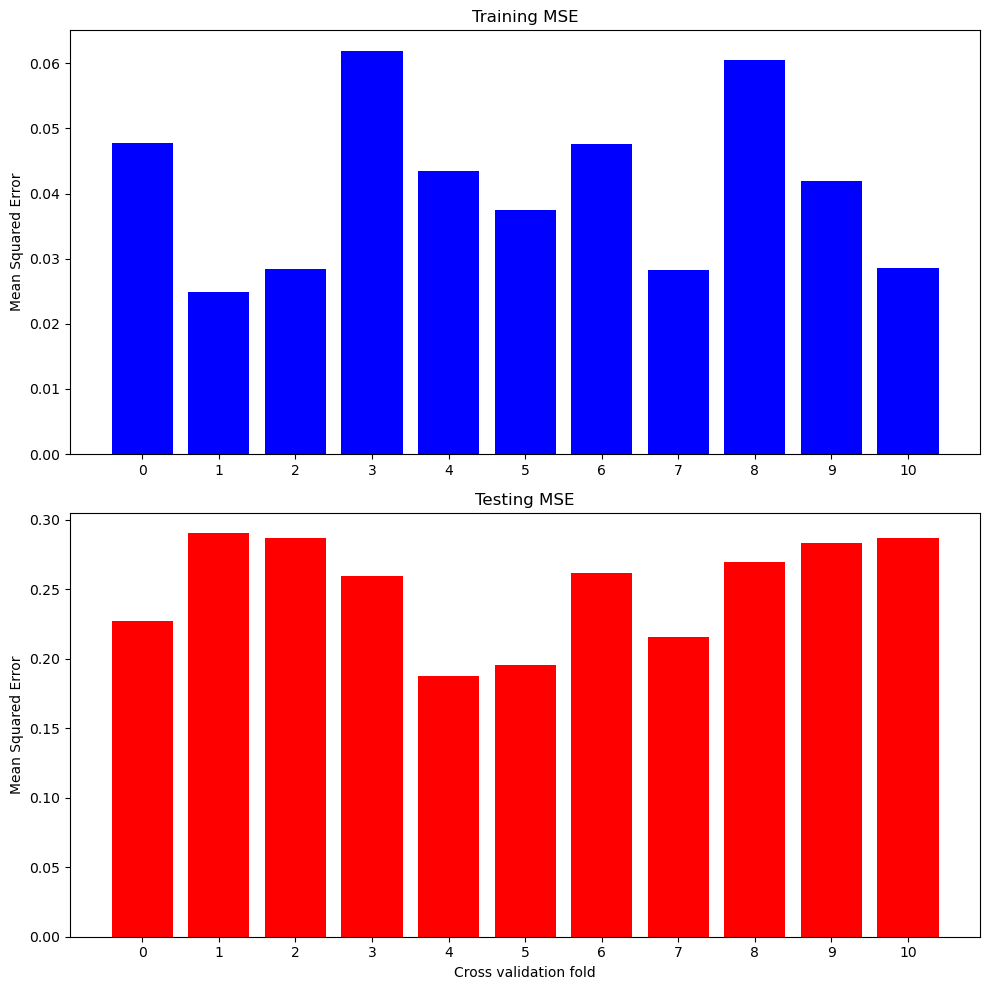

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# Plot the train bar chart
axs[0].bar(keys_train, values_train, color='blue')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_title('Training MSE')
axs[0].set_xticks(range(11))  # Set x-ticks to ensure they match for both subplots
axs[0].set_xticklabels(keys_train)  # Set x-tick labels to match the keys

# Plot the test bar chart
axs[1].bar(keys_test, values_test, color='red')
axs[1].set_xlabel('Cross validation fold')
axs[1].set_ylabel('Mean Squared Error')
axs[1].set_title('Testing MSE')
axs[1].set_xticks(range(11))  # Set x-ticks to ensure they match for both subplots
axs[1].set_xticklabels(keys_test)  # Set x-tick labels to match the keys

# Show the plot
plt.tight_layout()  # Adjusts the spacing between subplots
plt.show()

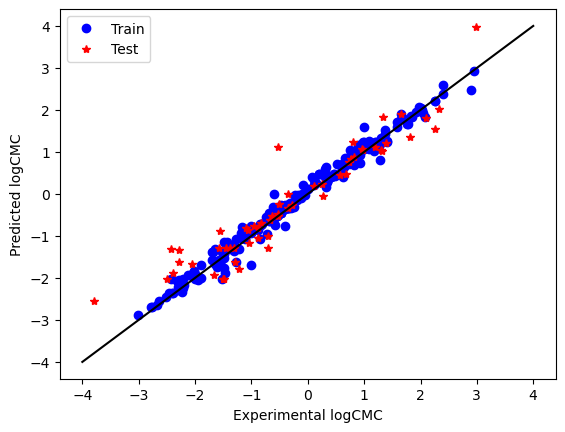

In [13]:
import matplotlib.pyplot as plt

train_exp   =  train['ep1000bs5lr0.005kf11hu256cvid5es.pth'][0]
train_pred  =  train['ep1000bs5lr0.005kf11hu256cvid5es.pth'][1]

test_exp    =  test['ep1000bs5lr0.005kf11hu256cvid5es.pth'][0]
test_pred   =  test['ep1000bs5lr0.005kf11hu256cvid5es.pth'][1]

plt.plot(train_exp, train_pred,'bo')
plt.plot(test_exp, test_pred,'r*')
#plt.plot([min(min(train_exp), min(train_pred)), max(max(train_exp), max(train_pred))],[min(min(train_exp), min(train_pred)), max(max(train_exp), max(train_pred))],'k-')
plt.plot([-4, 4],[-4, 4],'k-')
plt.xlabel('Experimental logCMC')
plt.ylabel('Predicted logCMC')
plt.legend(['Train','Test'])

# Use pretrained-model

In [16]:
import os

os.chdir("../")

In [17]:
from src.pretrainedmodel import GNNmodel

In [18]:
path = './models/GCN_early_stop' # or '../models/GCN'
model = GNNmodel(path = path)

In [19]:
predictions = model.predict([
                'CC(C)(C)CC(C)(C)c1ccc(OCCOCCO)cc1', 
                'CC(C)(C)CC(C)(C)c1ccc(OCCOCCOCCO)cc1',
                'CC(C)CCCC(C)CCCC(C)CCOC1OCC(O)C(O)C1O'
                ])


predictions

[-1.1431576013565063, -1.0029618442058563, -2.156362533569336]